In [131]:
from typing import List, Dict, Tuple, Callable, Union
import os, traceback, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import gc
import traceback
import warnings
from pdb import set_trace
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [132]:
weather = None

weather = pd.read_csv('weather_classification_data.csv')

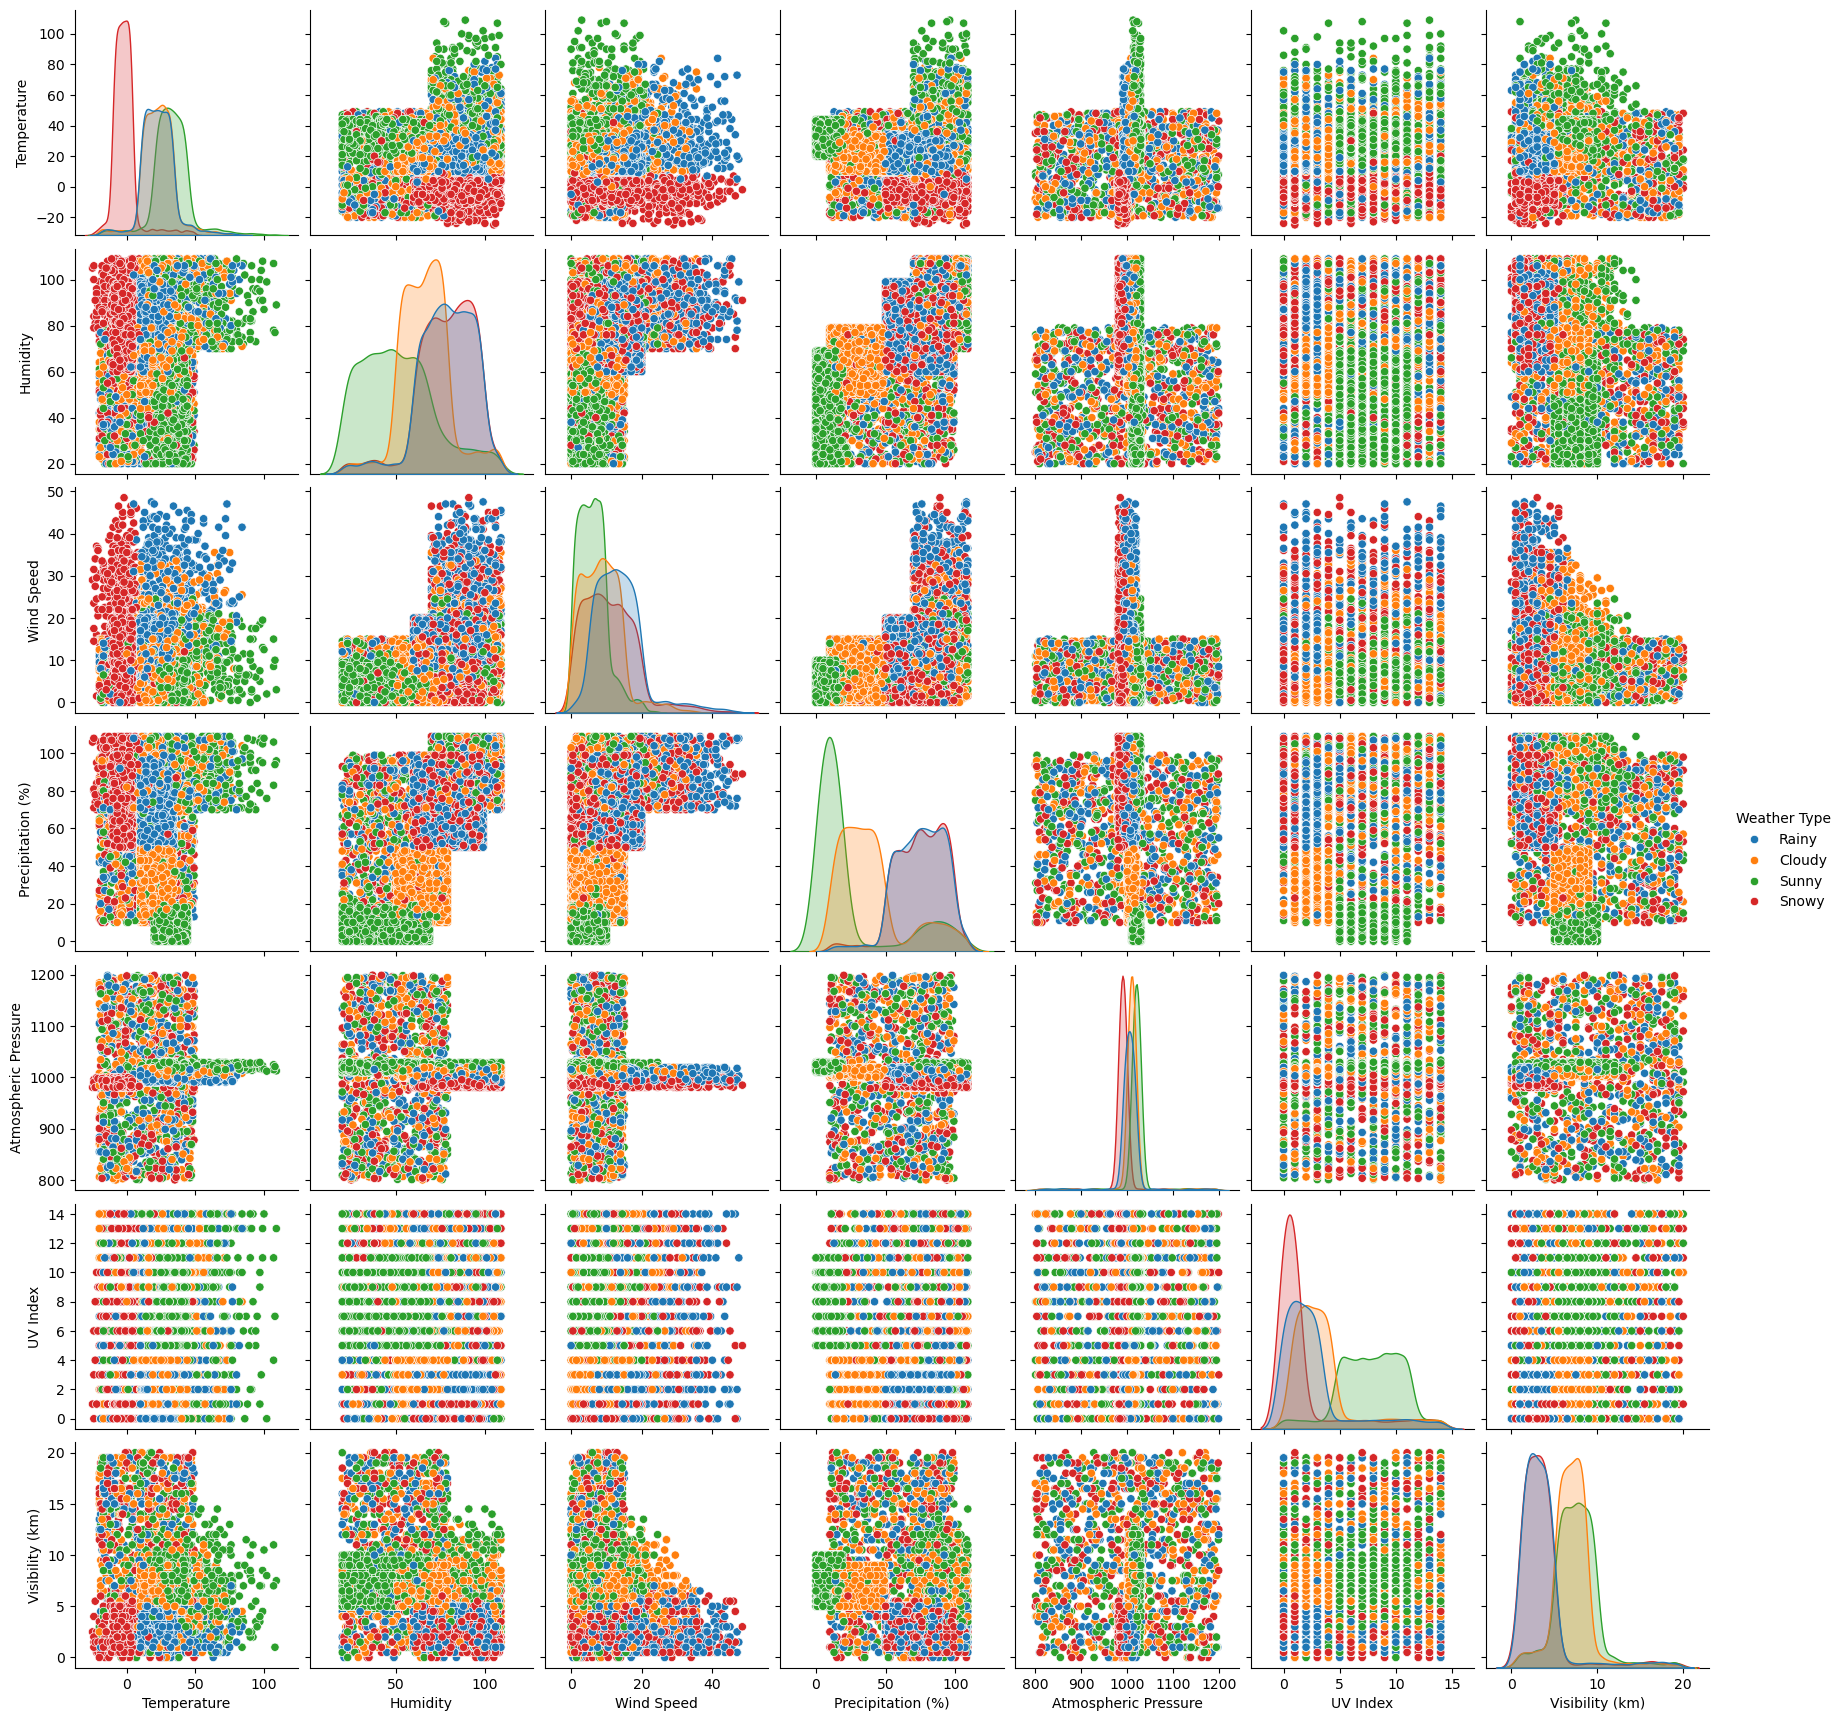

In [133]:
from seaborn import pairplot
weather_pairplot = weather
weather_pairplot = weather_pairplot.drop(columns=['Cloud Cover', 'Season', 'Location'])
pairplot = sns.pairplot(weather_pairplot, hue='Weather Type', diag_kind='kde')

In [134]:
label2name = { 
    0: 'Sunny', 1: 'Cloudy', 2: 'Snowy', 3: 'Rainy'
}

In [135]:
from sklearn.model_selection import train_test_split
def get_train_valid_test_data(
    X: np.ndarray, 
    y: np.ndarray, 
):
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, train_size=.8, random_state=42)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, train_size=.8, random_state=42)

    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

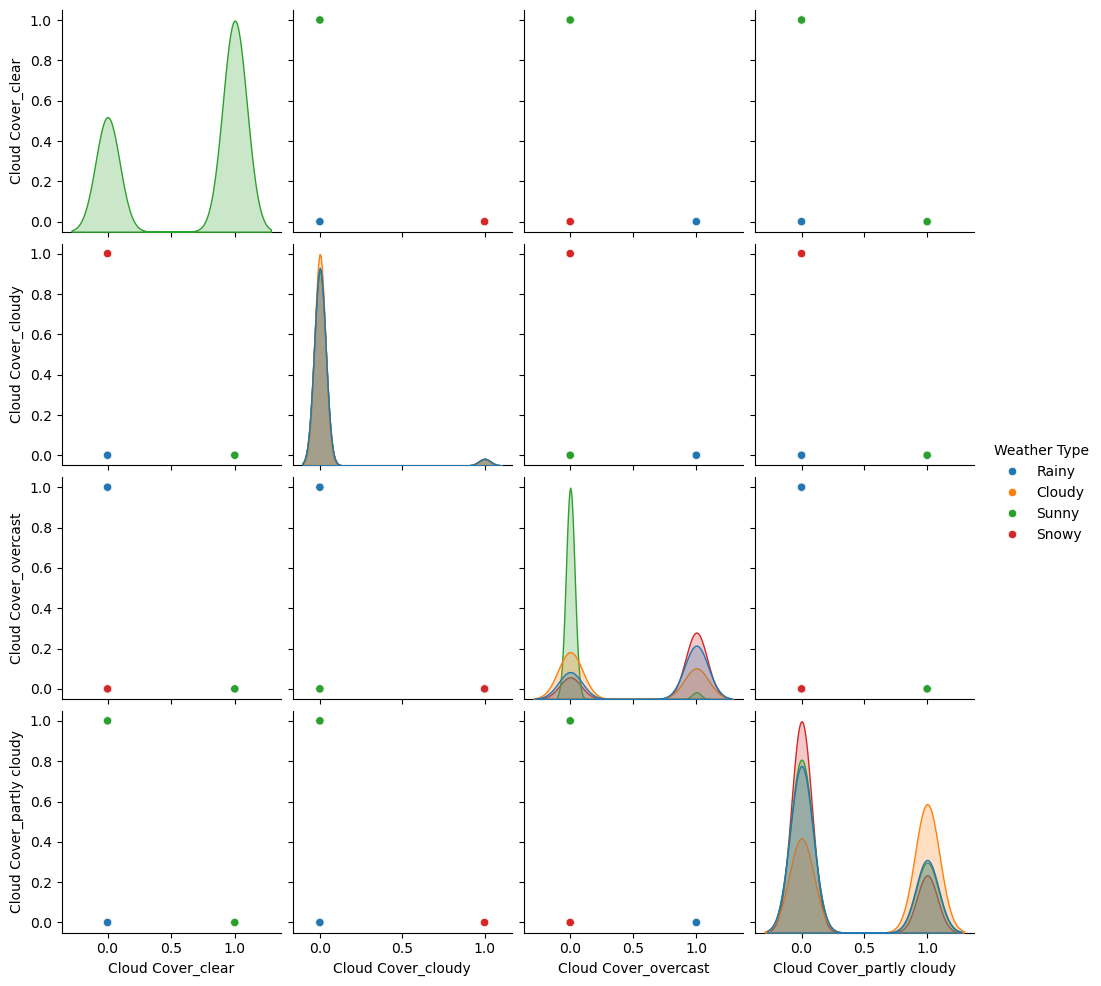

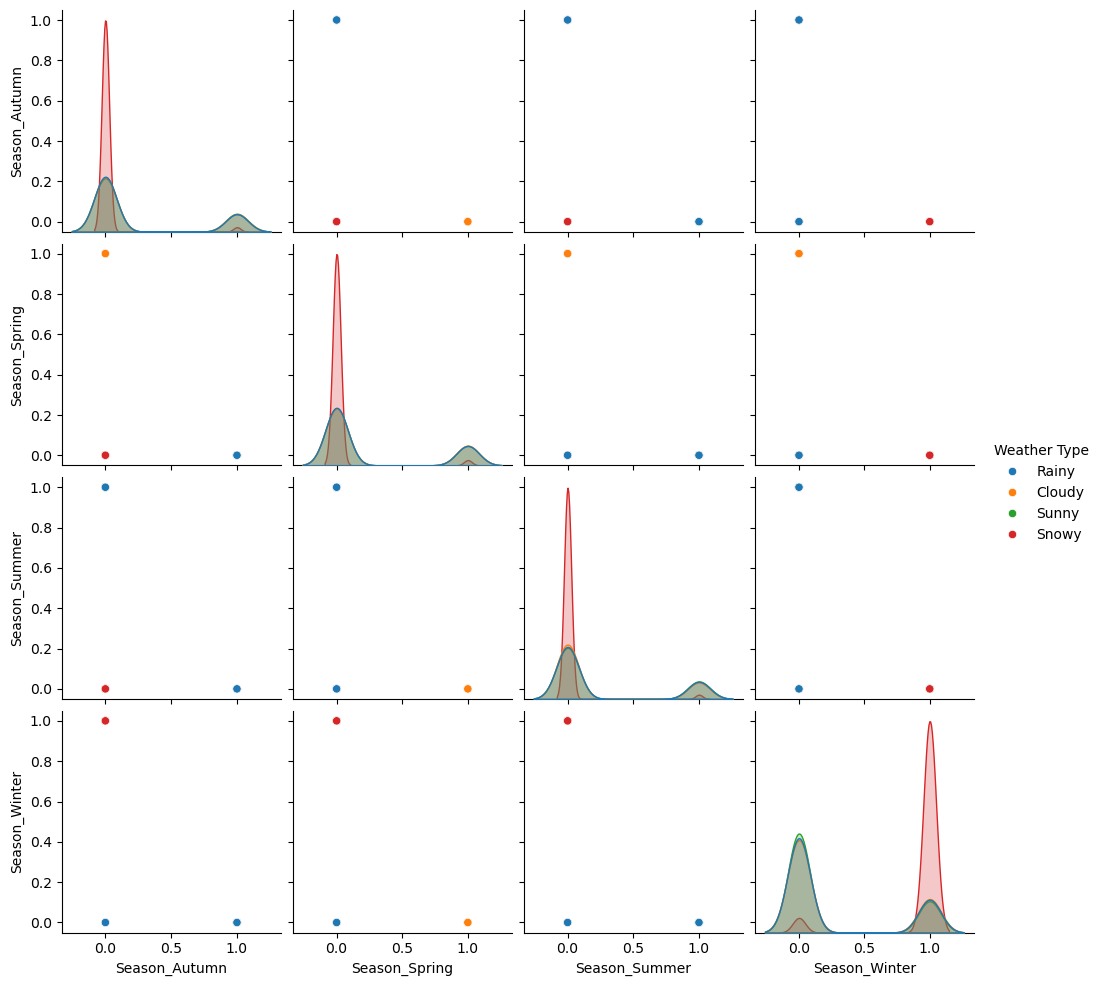

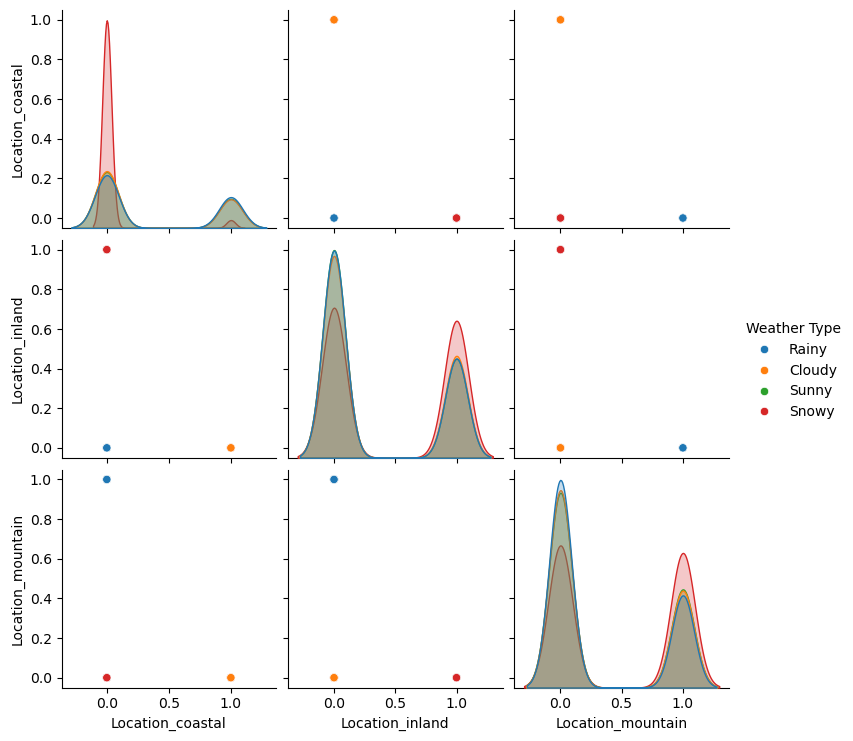

In [136]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
weather_sample = weather[['Weather Type']]
encoded = encoder.fit_transform(weather[['Cloud Cover']])
encoded = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(['Cloud Cover']))
weather_sampele = pd.concat([weather_sample, encoded], axis=1)
pairplot = sns.pairplot(weather_sampele, hue='Weather Type', diag_kind='kde')
weather = pd.concat([weather, encoded], axis=1)
weather = weather.drop(columns=['Cloud Cover'])
encoded = encoder.fit_transform(weather[['Season']])
encoded = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(['Season']))
weather_sampele = pd.concat([weather_sample, encoded], axis=1)
pairplot = sns.pairplot(weather_sampele, hue='Weather Type', diag_kind='kde')
weather = pd.concat([weather, encoded], axis=1)
weather = weather.drop(columns=['Season'])
encoded = encoder.fit_transform(weather[['Location']])
encoded = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out(['Location']))
weather_sampele = pd.concat([weather_sample, encoded], axis=1)
pairplot = sns.pairplot(weather_sampele, hue='Weather Type', diag_kind='kde')
weather = pd.concat([weather, encoded], axis=1)
weather = weather.drop(columns=['Location'])

In [137]:
#pairplot = sns.pairplot(weather, hue='Weather Type', diag_kind='kde')


In [138]:
def get_preprocessed_data() -> Tuple[np.ndarray]:
  
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = None, None, None, None, None, None
    X = weather.drop('Weather Type', axis=1).values
    y = weather['Weather Type'].values
    

    from sklearn.preprocessing import OneHotEncoder
    from sklearn.preprocessing import StandardScaler
    encoder = OneHotEncoder()
    scaler = StandardScaler()

    y = encoder.fit_transform(y.reshape(-1,1)).toarray()
    
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_train_valid_test_data(X, y)
    
    X_trn = scaler.fit_transform(X_trn)
    X_vld = scaler.transform(X_vld)
    X_tst = scaler.transform(X_tst)

    bias = np.ones((X_trn.shape[0],1))
    X_trn =  np.hstack((bias, X_trn))
    bias = np.ones((X_vld.shape[0],1))
    X_vld =  np.hstack((bias, X_vld))

    bias = np.ones((X_tst.shape[0],1))
    X_tst =  np.hstack((bias, X_tst))


    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

In [139]:
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data()
   
print(f"X_trn shape: {X_trn.shape}")
print(f"y_trn shape: {y_trn.shape}")
    
print(f"X_vld shape: {X_vld.shape}")
print(f"y_vld shape: {y_vld.shape}")
    
print(f"X_tst shape: {X_tst.shape}")
print(f"y_tst shape: {y_tst.shape}")

X_trn shape: (8448, 19)
y_trn shape: (8448, 4)
X_vld shape: (2112, 19)
y_vld shape: (2112, 4)
X_tst shape: (2640, 19)
y_tst shape: (2640, 4)


In [140]:
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix
)

In [141]:
def softmax(z: np.ndarray) -> np.ndarray:
    # TODO 5
    z_max = np.max(z, axis=1, keepdims=True)      
    z_stable = z - z_max                          
    exp_z = np.exp(z_stable)                     
    sum_exp = np.sum(exp_z, axis=1, keepdims=True) 
    return exp_z / sum_exp             
    pass

In [142]:
def nll_loss(y: np.ndarray, probs: np.ndarray) -> float:

    # TODO 6
    N = y.shape[0]
    loss = -np.sum(y * np.log(probs + 1e-15)) / N
    return loss
    pass

In [143]:
def get_batches(
    data_len: int, 
    batch_size: int = 32,
) -> List[np.ndarray]:

    indices = np.arange(data_len)
    np.random.shuffle(indices)
    batches = [indices[i:i+batch_size] for i in range(0, data_len, batch_size)]

    return batches

In [144]:
class SoftmaxRegression():

    def __init__(
        self, 
        alpha: float,
        batch_size: int,
        epochs: int = 1,
        seed: int = 0,
    ):

        self.alpha = alpha
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        
        self.W = None
        self.trn_loss = None
        self.vld_loss = None
    
    def fit(
         self, 
         X: np.ndarray, 
         y: np.ndarray, 
         X_vld: np.ndarray=None, 
         y_vld: np.ndarray=None
     ) -> object:
    
        np.random.seed(self.seed)
        self.trn_loss = []
        self.vld_loss = []

 
        self.W = None
        self.W = np.random.randn(X.shape[1], y.shape[1])
        for e in range(self.epochs):
            batches = get_batches(X.shape[0],self.batch_size)
            for b in batches:
                z = X[b] @ self.W
                y_hat = softmax(z)
                grad = X[b].T @ (y_hat - y[b]) / len(b)
                self.W -= self.alpha * grad

            trn_probs = softmax(X @ self.W)
            trn_loss = nll_loss(y, trn_probs)
            self.trn_loss.append(trn_loss)

            if X_vld is not None and y_vld is not None:
                vld_probs = softmax(X_vld @ self.W)
                vld_loss = nll_loss(y_vld, vld_probs)
                self.vld_loss.append(vld_loss)
            
        return self
        
    def predict(self, X: np.ndarray) -> np.ndarray:
      
        y_hat = (X @ self.W)
        y_hat = np.argmax(y_hat, axis =1)
        return y_hat
        pass

In [145]:
def plot_confusion_matrix(
    y: np.ndarray, 
    y_hat: np.ndarray, 
    class_names: Dict[int, str] = None,
    figsize: Tuple = (10, 5)
) -> pd.DataFrame:

    y =  y.flatten() 
    y_hat = y_hat.flatten() 
    
    cfm = confusion_matrix(y_true=y, y_pred=y_hat)    
    
    labels = np.sort(np.unique(y))
    if class_names is not None:
        classes = []
        for l in labels:
            class_name = class_names.get(l, l)
            classes.append(class_name)
        labels = classes
        
    columns, index = labels, labels
    fig, ax = plt.subplots(figsize=figsize)  
    cfm_df = pd.DataFrame(cfm, index=index, columns=columns)
    sns.heatmap(cfm_df, annot=True, fmt='g', ax=ax)
    plt.show()
    return cfm_df

X_trn shape: (8448, 19)
Train Accuracy: 0.8740530303030303


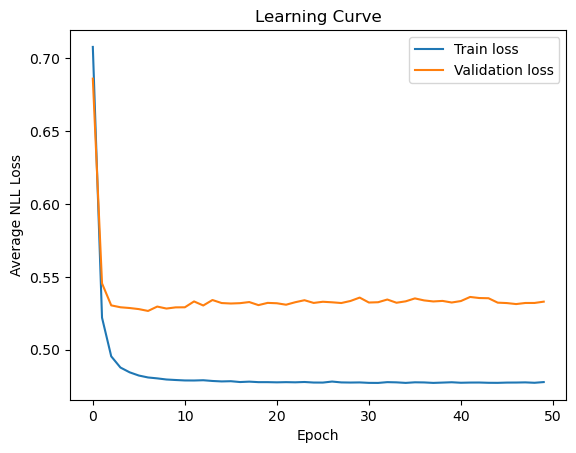

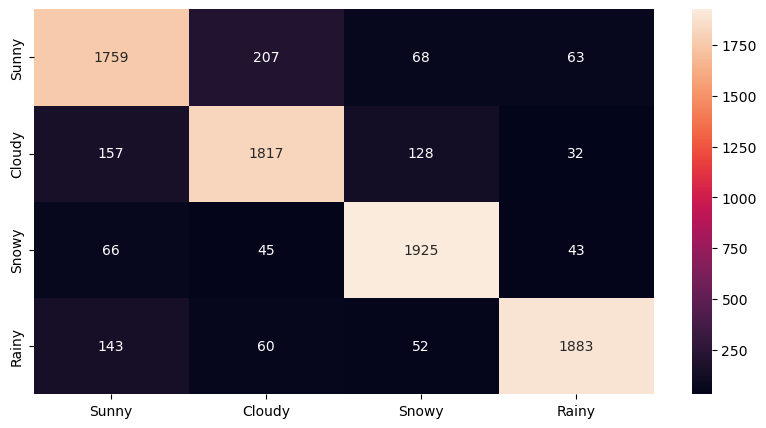

Sunny  Cloudy  Snowy  Rainy
Sunny    1759     207     68     63
Cloudy    157    1817    128     32
Snowy      66      45   1925     43
Rainy     143      60     52   1883

In [176]:
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data()
print(f"X_trn shape: {X_trn.shape}")
softreg = SoftmaxRegression(epochs=50, batch_size=32, alpha=.05, seed=42)
softreg.fit(X_trn, y_trn, X_vld=X_vld, y_vld=y_vld)
y_hat = softreg.predict(X_trn)
test_acc = accuracy_score(np.argmax(y_trn, axis=1), y_hat)
print(f"Train Accuracy: {test_acc}")

plt.plot(softreg.trn_loss, label='Train loss')
plt.plot(softreg.vld_loss, label='Validation loss')
plt.title("Learning Curve")
plt.ylabel("Average NLL Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

plot_confusion_matrix(np.argmax(y_trn, axis=1), y_hat, class_names=label2name)

Validation Accuracy:  0.8612689393939394


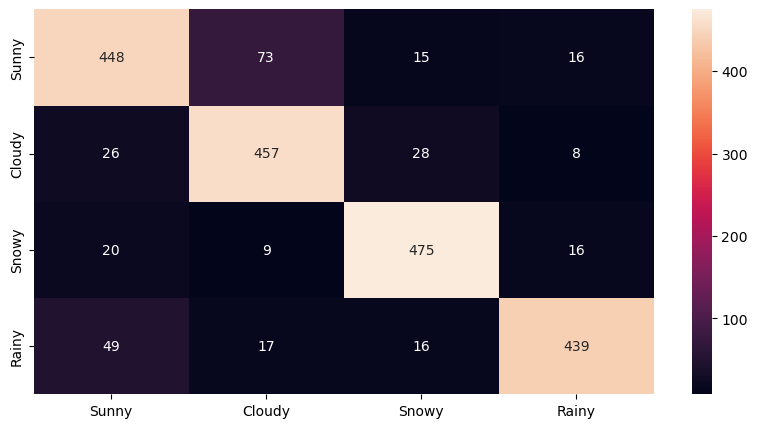

Sunny  Cloudy  Snowy  Rainy
Sunny     448      73     15     16
Cloudy     26     457     28      8
Snowy      20       9    475     16
Rainy      49      17     16    439

In [173]:
test_acc = accuracy_score(np.argmax(y_vld, axis=1), softreg.predict(X_vld))
print("Validation Accuracy: ", test_acc)
plot_confusion_matrix(np.argmax(y_vld, axis=1), softreg.predict(X_vld), class_names=label2name)

Test Accuracy:  0.8681818181818182


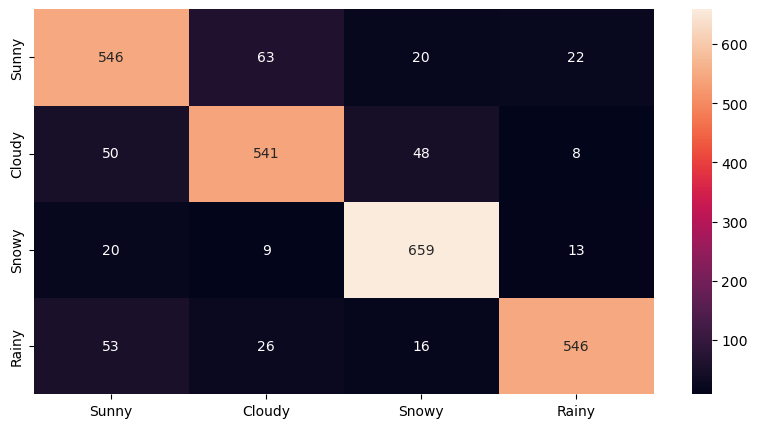

Sunny  Cloudy  Snowy  Rainy
Sunny     546      63     20     22
Cloudy     50     541     48      8
Snowy      20       9    659     13
Rainy      53      26     16    546

In [174]:
test_acc = accuracy_score(np.argmax(y_tst, axis=1), softreg.predict(X_tst))
print("Test Accuracy: ", test_acc)
plot_confusion_matrix(np.argmax(y_tst, axis=1), softreg.predict(X_tst), class_names=label2name)